# Project Work of Deep Learning
- Irene Burri 0001120380


## Problem: Water Mapping using Satellite Imagery
Accurately detecting and segmenting waterbodies (rivers, lakes, reservoirs, and oceans) from satellite imagery is essential for effective environmental monitoring, water resource management, and disaster mitigation.

This notebook focuses on building a deep learning based **U-Net model** to **automate waterbody segmentation**. The goal is to enable fast, reliable, and scalable identification of water regions within satellite images, offering a significant improvement over traditional methods in both efficiency and accuracy.
## Dataset: Images and Masks of Satellite Images of Water Bodies for Image Segmentation
It's a collection of **water bodies images** captured by the Sentinel-2 Satellite. Each image comes with a black and white mask where white represents water and black represents something else but water. The masks were generated by calculating the NWDI (Normalized Water Difference Index) which is frequently used to detect and measure vegetation in satellite images, but a greater threshold was used to detect water bodies.

Reference: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies/data

Structure:
- Images: contains 2841 files .jpg
- Masks: contains the corresponding 2841 masks .jpg

## Import Essential Libraries

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import Sequence
from tqdm.auto import tqdm
from PIL import Image

## Data Loading
To handle the large dataset size, it was uploaded as multiple ZIP files to a GitHub repository and later extracted locally for use.

In [ ]:
# Clone the GitHub repository containing the dataset and project files
!git clone https://github.com/ireneburri/PW_DeepLearning.git
%cd PW_DeepLearning

Cloning into 'PW_DeepLearning'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 29 (delta 3), reused 3 (delta 1), pack-reused 18 (from 3)
Receiving objects: 100% (29/29), 247.00 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (6/6), done.
/content/PW_DeepLearning


In [ ]:
# Unzip all dataset files (masks and images) into their respective folders
!unzip -j /content/PW_DeepLearning/Data/Masks.zip -d Data/Masks
!unzip -j /content/PW_DeepLearning/Data/Images1.zip -d Data/Images
!unzip -j /content/PW_DeepLearning/Data/Images2.zip -d Data/Images

In [ ]:
IMG_DATA = "/content/PW_DeepLearning/Data/Images"
MASK_DATA = "/content/PW_DeepLearning/Data/Masks"
IMAGES =  next(os.walk(IMG_DATA))[2]
MASKS = next(os.walk(MASK_DATA))[2]

## Data Exploration
- The data has already been filtered and appears clean enough for further processing.
- Each file has a unique name, ensuring there are no duplicates.

In [ ]:
print(f"There are total of {len(IMAGES)} images and {len(MASKS)} masks in the given dataset.")

There are total of 2841 images and 2841 masks in the given dataset.


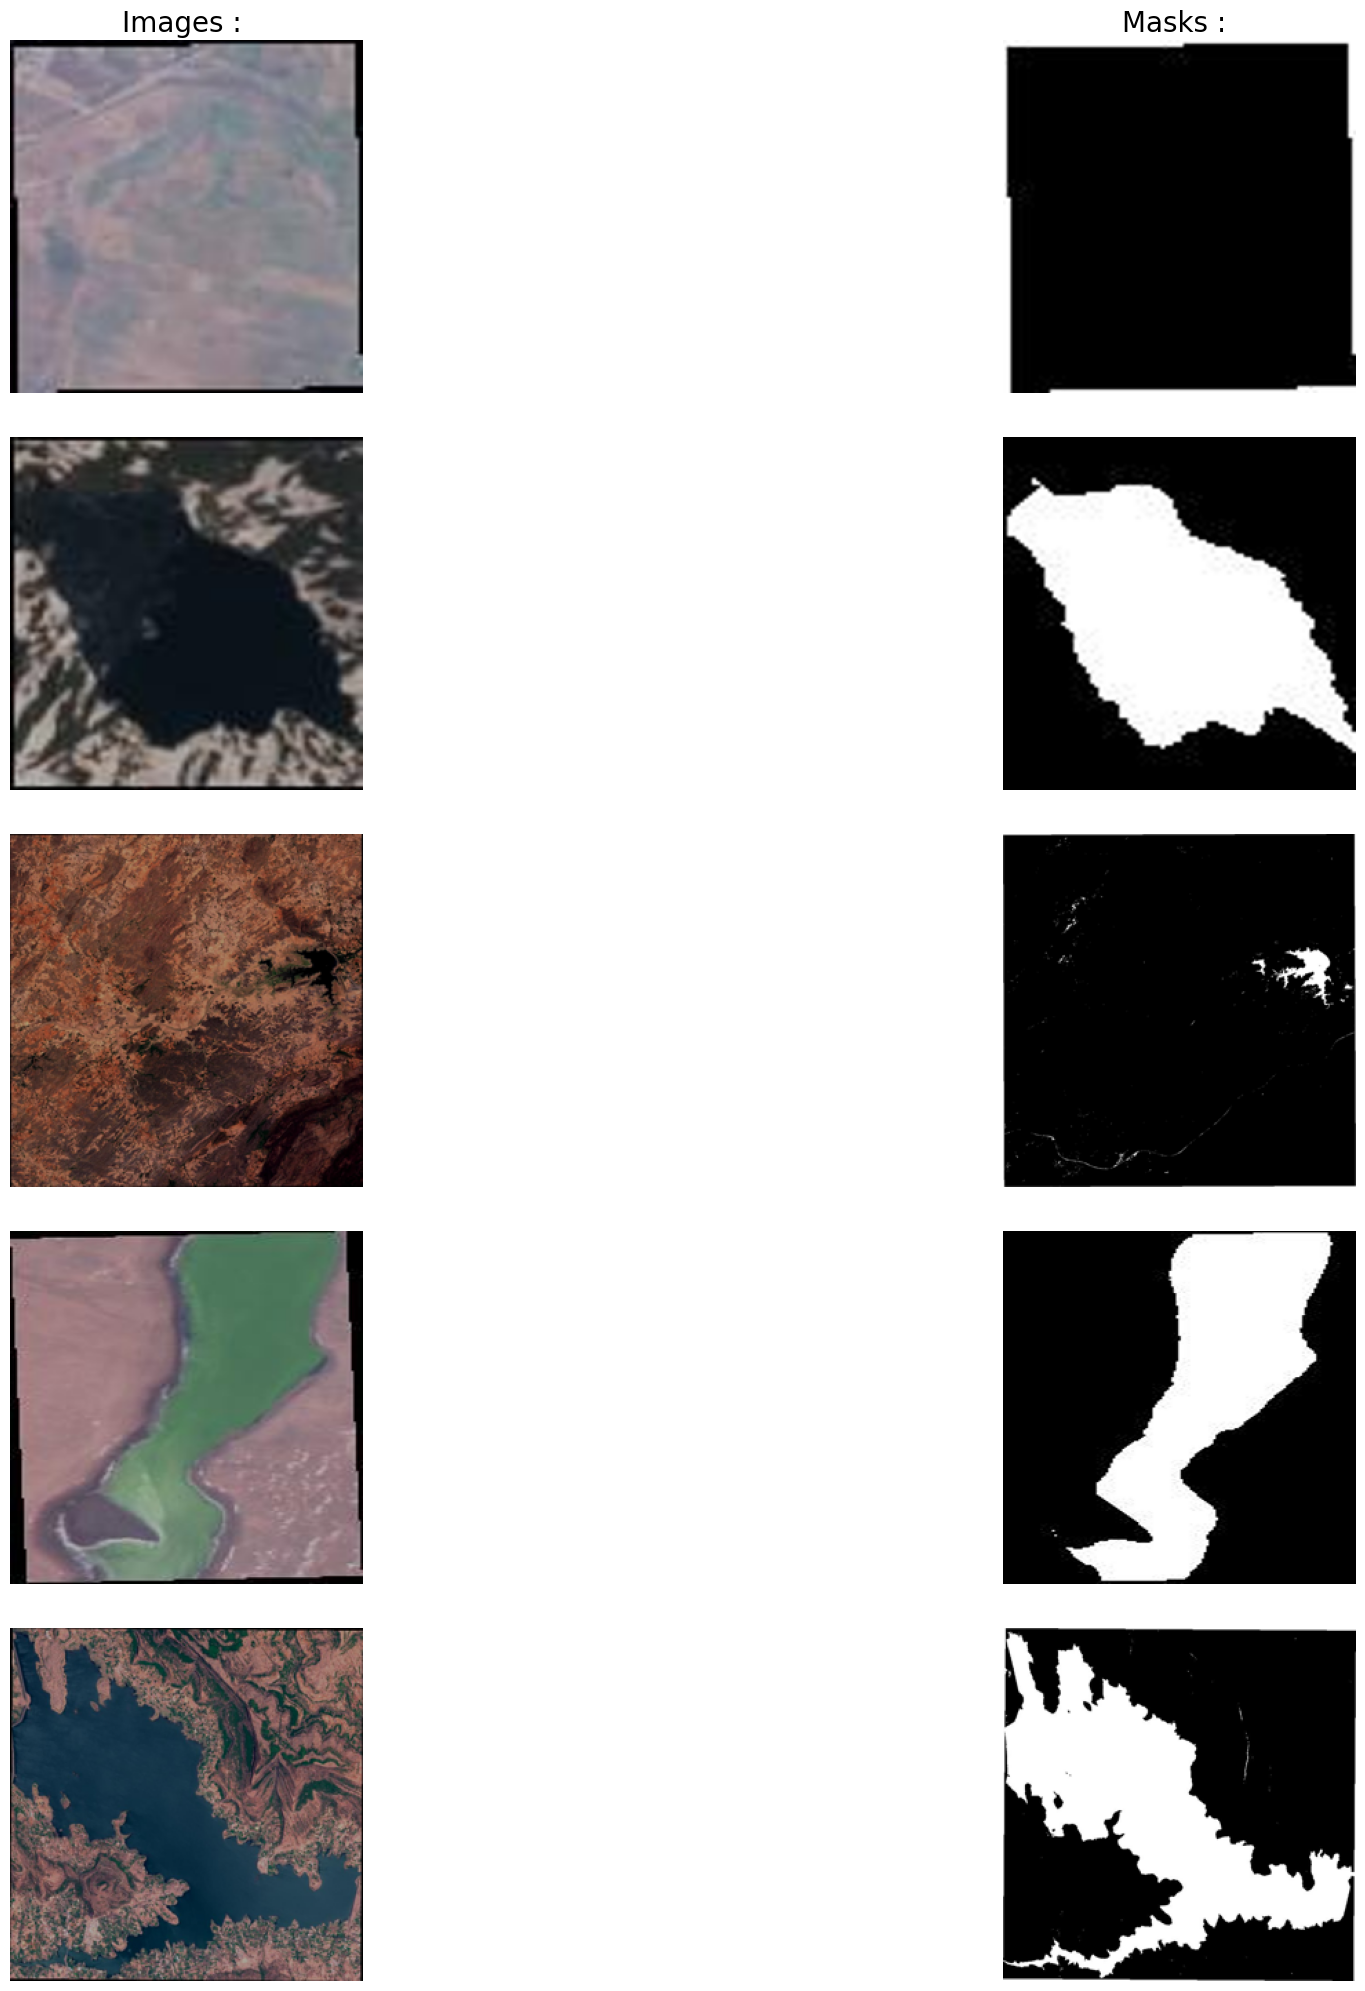

In [ ]:
# Display 5 random images and their corresponding masks from the dataset
indeces = np.random.randint(0, len(IMAGES), 5)

fig, ax = plt.subplots(5, 2, figsize=(20, 20))
fig.tight_layout()
ax[0, 0].set_title("Images : ", fontsize=20)
ax[0, 1].set_title("Masks : ", fontsize=20)
for i, idx in enumerate(indeces):
    image = Image.open(IMG_DATA + "/" + IMAGES[idx])
    mask = Image.open(MASK_DATA + "/" + MASKS[idx])
    image = image.resize((256, 256))
    mask = mask.resize((256, 256))
    ax[i, 0].imshow(image)
    ax[i, 0].axis("off")
    ax[i, 1].imshow(mask)
    ax[i, 1].axis("off")

## Data Preparation

In [ ]:
# Splitting the dataset into training and validation sets
split_size = 0.2
last_idx = int(np.floor((1 - split_size) * len(IMAGES)))
X_train = IMAGES[:last_idx]
Y_train = MASKS[:last_idx]
X_val = IMAGES[last_idx:]
Y_val = MASKS[last_idx:]

In [ ]:
# Display the number of images and masks in each set
print(f"X_train contains {len(X_train)} images.")
print(f"Y_train contains {len(Y_train)} masks.")
print(f"X_val contains {len(X_val)} images.")
print(f"Y_val contains {len(Y_val)} masks.")

X_train contains 2272 images.
Y_train contains 2272 masks.
X_val contains 569 images.
Y_val contains 569 masks.


## Custom Data Generator for Image Segmentation

I define a custom data generator using `tf.keras.utils.Sequence` for efficiently loading and preprocessing satellite images and their corresponding masks in batches. The generator is used during the training and validation phases to provide data for model training.

- Arguments:
  - `image_filenames`: List of filenames for the input images.
  - `mask_filenames`: List of filenames for the corresponding segmentation masks.
  - `image_dir`: Directory path where the images are stored.
  - `mask_dir`: Directory path where the masks are stored.
  - `batch_size`: Number of samples per batch.
  - `img_size`: Desired size for the images (height, width).
  - `shuffle`: Whether to shuffle the data after each epoch.

The generator ensures that the images and masks are preprocessed correctly (resizing, normalization) and batches are returned in a format suitable for training the model.

In [ ]:
# The ImageSegmentationGenerator inherits from the Keras Sequence class, ensuring that data loading
# is done in a multi-threaded and efficient way. It will return batches of data for model training

class ImageSegmentationGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, image_dir, mask_dir, batch_size, img_size=(256, 256), shuffle=True):
        # Initialize the generator with the given parameters
        super().__init__()
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # The length of the generator determines how many batches are returned per epoch.
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        # Get the batch of image and mask filenames based on the current batch index
        batch_img_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_filenames = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for img_filename, mask_filename in zip(batch_img_filenames, batch_mask_filenames):

            # Load and preprocess the Image
            img_path = os.path.join(self.image_dir, img_filename)
            image = Image.open(img_path).convert("RGB") # Convert to RGB
            image = image.resize(self.img_size) # Resize image to the target size
            image = np.asarray(image, dtype=np.float32) # Convert to numpy array
            batch_images.append(image)

            # Load and preprocess the Mask
            mask_path = os.path.join(self.mask_dir, mask_filename)
            mask = Image.open(mask_path).convert("L") # Convert to grayscale
            mask = mask.resize(self.img_size) # Resize mask to the target size
            mask = np.asarray(mask, dtype=np.float32) / 255.0 # Normalize mask values to [0, 1]
            batch_masks.append(mask)

        # Convert to arrays
        batch_images = np.array(batch_images)
        batch_masks = np.expand_dims(np.array(batch_masks), axis=-1)  # Add channel dimension to masks

        return batch_images, batch_masks

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_filenames, self.mask_filenames))
            np.random.shuffle(combined)
            self.image_filenames, self.mask_filenames = zip(*combined)

## Building the Base U-Net Model

Definition of the architecture of the U-Net model. I decided to use a U-Net model since it's a type of convolutional neural network designed for semantic segmentation tasks, where the objective is to classify each pixel of an image.

- The model consists of two main parts:
  - **Encoder**: Extracts features from the input image using convolutional layers followed by max-pooling operations.
  - **Bottleneck**: This part is the narrowest part of the U-Net, where the network learns the most abstract representations of the image.
  - **Decoder**: Expands the feature maps back to the original image size using transposed convolutions, enabling pixel-wise segmentation.

I use **ReLU activations** in convolutional layers and **batch normalization** for regularization, which helps stabilize the training process.

### Model Summary and Size

The resulting model is quite big, with over 31 million parameters in total. This includes:
- Trainable parameters: 31,043,521
- Non-trainable parameters: 11,776

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

# Model is divided into 3 sections: Encoder, Bottleneck, Decoder

inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
std_inputs = tf.keras.layers.Lambda(lambda x:x/255)(inputs)

### Encoder

# Convolutional block 1
conv1_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(std_inputs)
conv1_1 = tf.keras.layers.BatchNormalization()(conv1_1)
conv1_1 = tf.keras.layers.ReLU()(conv1_1)
conv1_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv1_1)
conv1_2 = tf.keras.layers.BatchNormalization()(conv1_2)
conv1_2 = tf.keras.layers.ReLU()(conv1_2)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1_2)

# Convolutional block 2
conv2_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool1)
conv2_1 = tf.keras.layers.BatchNormalization()(conv2_1)
conv2_1 = tf.keras.layers.ReLU()(conv2_1)
conv2_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv2_1)
conv2_2 = tf.keras.layers.BatchNormalization()(conv2_2)
conv2_2 = tf.keras.layers.ReLU()(conv2_2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)

# Convolutional block 3
conv3_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool2)
conv3_1 = tf.keras.layers.BatchNormalization()(conv3_1)
conv3_1 = tf.keras.layers.ReLU()(conv3_1)
conv3_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv3_1)
conv3_2 = tf.keras.layers.BatchNormalization()(conv3_2)
conv3_2 = tf.keras.layers.ReLU()(conv3_2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3_2)

# Convolutional block 4
conv4_1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool3)
conv4_1 = tf.keras.layers.BatchNormalization()(conv4_1)
conv4_1 = tf.keras.layers.ReLU()(conv4_1)
conv4_2 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv4_1)
conv4_2 = tf.keras.layers.BatchNormalization()(conv4_2)
conv4_2 = tf.keras.layers.ReLU()(conv4_2)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4_2)

### Bottleneck

# Bottleneck Block
bn_conv_1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool4)
bn_conv_1 = tf.keras.layers.BatchNormalization()(bn_conv_1)
bn_conv_1 = tf.keras.layers.ReLU()(bn_conv_1)
bn_conv_2 = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(bn_conv_1)
bn_conv_2 = tf.keras.layers.BatchNormalization()(bn_conv_2)
bn_conv_2 = tf.keras.layers.ReLU()(bn_conv_2)

### Decoder

# Reverse Convolutional Block 1
upconv1 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(2, 2), strides=(2, 2), padding="same", kernel_initializer="he_normal")(bn_conv_2)
upconv1 = tf.keras.layers.Concatenate()([conv4_2, upconv1])
conv5_1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(upconv1)
conv5_1 = tf.keras.layers.BatchNormalization()(conv5_1)
conv5_1 = tf.keras.layers.ReLU()(conv5_1)
conv5_2 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv5_1)
conv5_2 = tf.keras.layers.BatchNormalization()(conv5_2)
conv5_2 = tf.keras.layers.ReLU()(conv5_2)

# Reverse Convolutional Block 2
upconv2 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding="same", kernel_initializer="he_normal")(conv5_2)
upconv2 = tf.keras.layers.Concatenate()([conv3_2, upconv2])
conv6_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(upconv2)
conv6_1 = tf.keras.layers.BatchNormalization()(conv6_1)
conv6_1 = tf.keras.layers.ReLU()(conv6_1)
conv6_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv6_1)
conv6_2 = tf.keras.layers.BatchNormalization()(conv6_2)
conv6_2 = tf.keras.layers.ReLU()(conv6_2)

# Reverse Convolutional Block 3
upconv3 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding="same", kernel_initializer="he_normal")(conv6_2)
upconv3 = tf.keras.layers.Concatenate()([conv2_2, upconv3])
conv7_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(upconv3)
conv7_1 = tf.keras.layers.BatchNormalization()(conv7_1)
conv7_1 = tf.keras.layers.ReLU()(conv7_1)
conv7_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv7_1)
conv7_2 = tf.keras.layers.BatchNormalization()(conv7_2)
conv7_2 = tf.keras.layers.ReLU()(conv7_2)

# Reverse Convolutional Block 4
upconv4 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding="same", kernel_initializer="he_normal")(conv7_2)
upconv4 = tf.keras.layers.Concatenate()([conv1_2, upconv4])
conv8_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(upconv4)
conv8_1 = tf.keras.layers.BatchNormalization()(conv8_1)
conv8_1 = tf.keras.layers.ReLU()(conv8_1)
conv8_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(conv8_1)
conv8_2 = tf.keras.layers.BatchNormalization()(conv8_2)
conv8_2 = tf.keras.layers.ReLU()(conv8_2)

outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(conv8_2)

In [ ]:
# Create model from input and output layers
unet = tf.keras.Model(inputs=[inputs], outputs=[outputs])
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

## Model Compilation

The U-Net model is compled with:
- Optimizer: **Adam optimizer** with a learning rate of 1e-4.
- Loss Function: **Binary Crossentropy**, suitable for water vs non-water segmentation.
- Metrics: **Accuracy**.

We also define two callbacks to prevent overfitting and improve model convergence:
- **ReduceLROnPlateau**: This reduces the learning rate by a factor of 0.5 if the validation loss plateaus for 5 consecutive epochs, with a minimum learning rate of `1e-6`.
- **EarlyStopping**: Stops training if the validation loss does not improve for 10 epochs, restoring the model to the best weights seen.

In [ ]:
# Define the learing rate and the optimizer and compile the model with binary crossentropy loss and accuracy metric.
LR = 1e-4
optimizer = tf.keras.optimizers.Adam(LR)
unet.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Define callbacks for learning rate adjustment and early stopping.
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                 factor=0.5,
                                 patience=5,
                                 min_lr=1e-6,
                                 verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=10,
                                  restore_best_weights=True,
                                  mode="min",
                                  verbose=1)
]

## Model Training
The `ImageSegmentationGenerator` is used to load batches of images and masks.
- **Batch Size**: 32 images per batch.
- **Epochs**: Train the model for up to 50 epochs with the defined callbacks for early stopping and learning rate reduction.


In [ ]:
# Create train and validation generators to feed data into the model
train_generator = ImageSegmentationGenerator(X_train, Y_train, IMG_DATA, MASK_DATA, batch_size=32)
val_generator = ImageSegmentationGenerator(X_val, Y_val, IMG_DATA, MASK_DATA, batch_size=32)

history = unet.fit(x=train_generator,
                   validation_data=val_generator,
                   batch_size=32,
                   # batch_size=64,
                   epochs=50,
                   callbacks=callbacks,
                  )

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


71/71 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.6359 - loss: 0.5292 - val_accuracy: 0.5393 - val_loss: 0.9095 - learning_rate: 1.0000e-04
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7353 - loss: 0.3659 - val_accuracy: 0.6313 - val_loss: 0.7191 - learning_rate: 1.0000e-04
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7456 - loss: 0.3347 - val_accuracy: 0.6982 - val_loss: 0.4536 - learning_rate: 1.0000e-04
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7526 - loss: 0.3177 - val_accuracy: 0.7401 - val_loss: 0.3470 - learning_rate: 1.0000e-04
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7666 - loss: 0.2886 - val_accuracy: 0.7403 - val_loss: 0.3448 - learning_rate: 1.0000e-04
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7637 - loss: 0.2934 - val_accuracy: 0.7717 - val_loss: 0.2996 - learning_rate: 1.0000e-04
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7708 - loss: 0.2

## Model Results Analysis

### Model Performance and Early Stopping
- Best Epoch: **Epoch 32** achieved the best validation loss and the model was restored to this checkpoint. Early stopping was correctly applied to avoid unnecessary training and potential degradation.
- Key Metrics at Best Epoch
    - Training Accuracy: 81.91%
    - Validation Accuracy: **79.72%**
    - Training Loss: 0.1200
    - Validation Loss: **0.2358**
- Learning Rate Scheduling: The use of ReduceLROnPlateau was appropriate: it kicked in at epoch 42, reducing the learning rate to fine-tune model weights further.

### Comparison plot of Training Accuracy vs. Validation Accuracy
- Initial Growth: The model shows a steep rise in both training and validation accuracy during the first 10–15 epochs. This is expected as the model quickly learns basic patterns and representations.
- Plateau & Gap: After around epoch 20, training accuracy continues to improve steadily, while validation accuracy begins to plateau, hovering just below 80%.
- Generalization: The small but consistent gap between training and validation accuracy indicates an overfitting. However, it's not drastic and suggests that the model is still generalizing reasonably well.

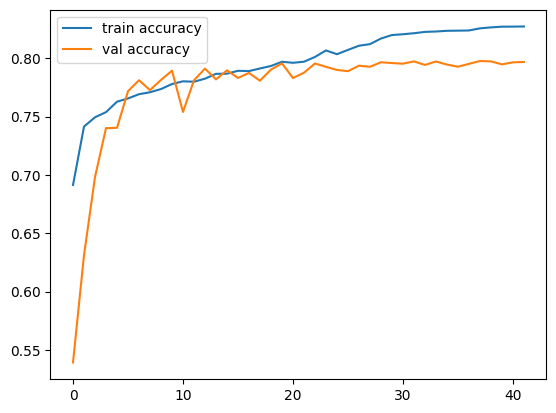

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train accuracy", "val accuracy"])
plt.show()

### Comparison plot for Training Loss and Validation Loss
- Loss Convergence: Training loss steadily decreases throughout, reaching about 0.097 by epoch 42, which is a strong indication of good convergence.
- Validation Loss Plateau: Validation loss drops significantly early on and then flattens out around 0.23-0.25, showing that the model is no longer significantly improving on unseen data.
- Overfitting Signs: Similar to the accuracy plot, the validation loss starts to diverge slightly from the training loss after epoch 25. This reinforces the indication of overfitting-



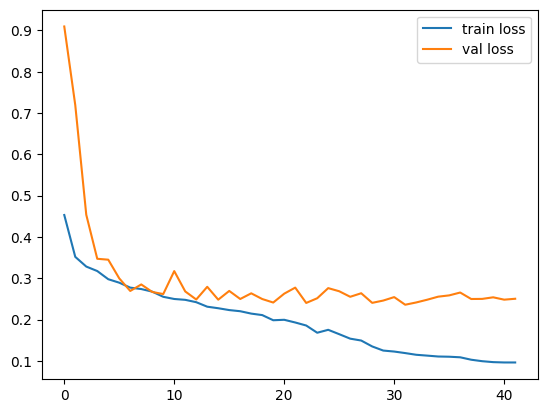

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train loss", "val loss"])
plt.show()

## Prediction Results

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


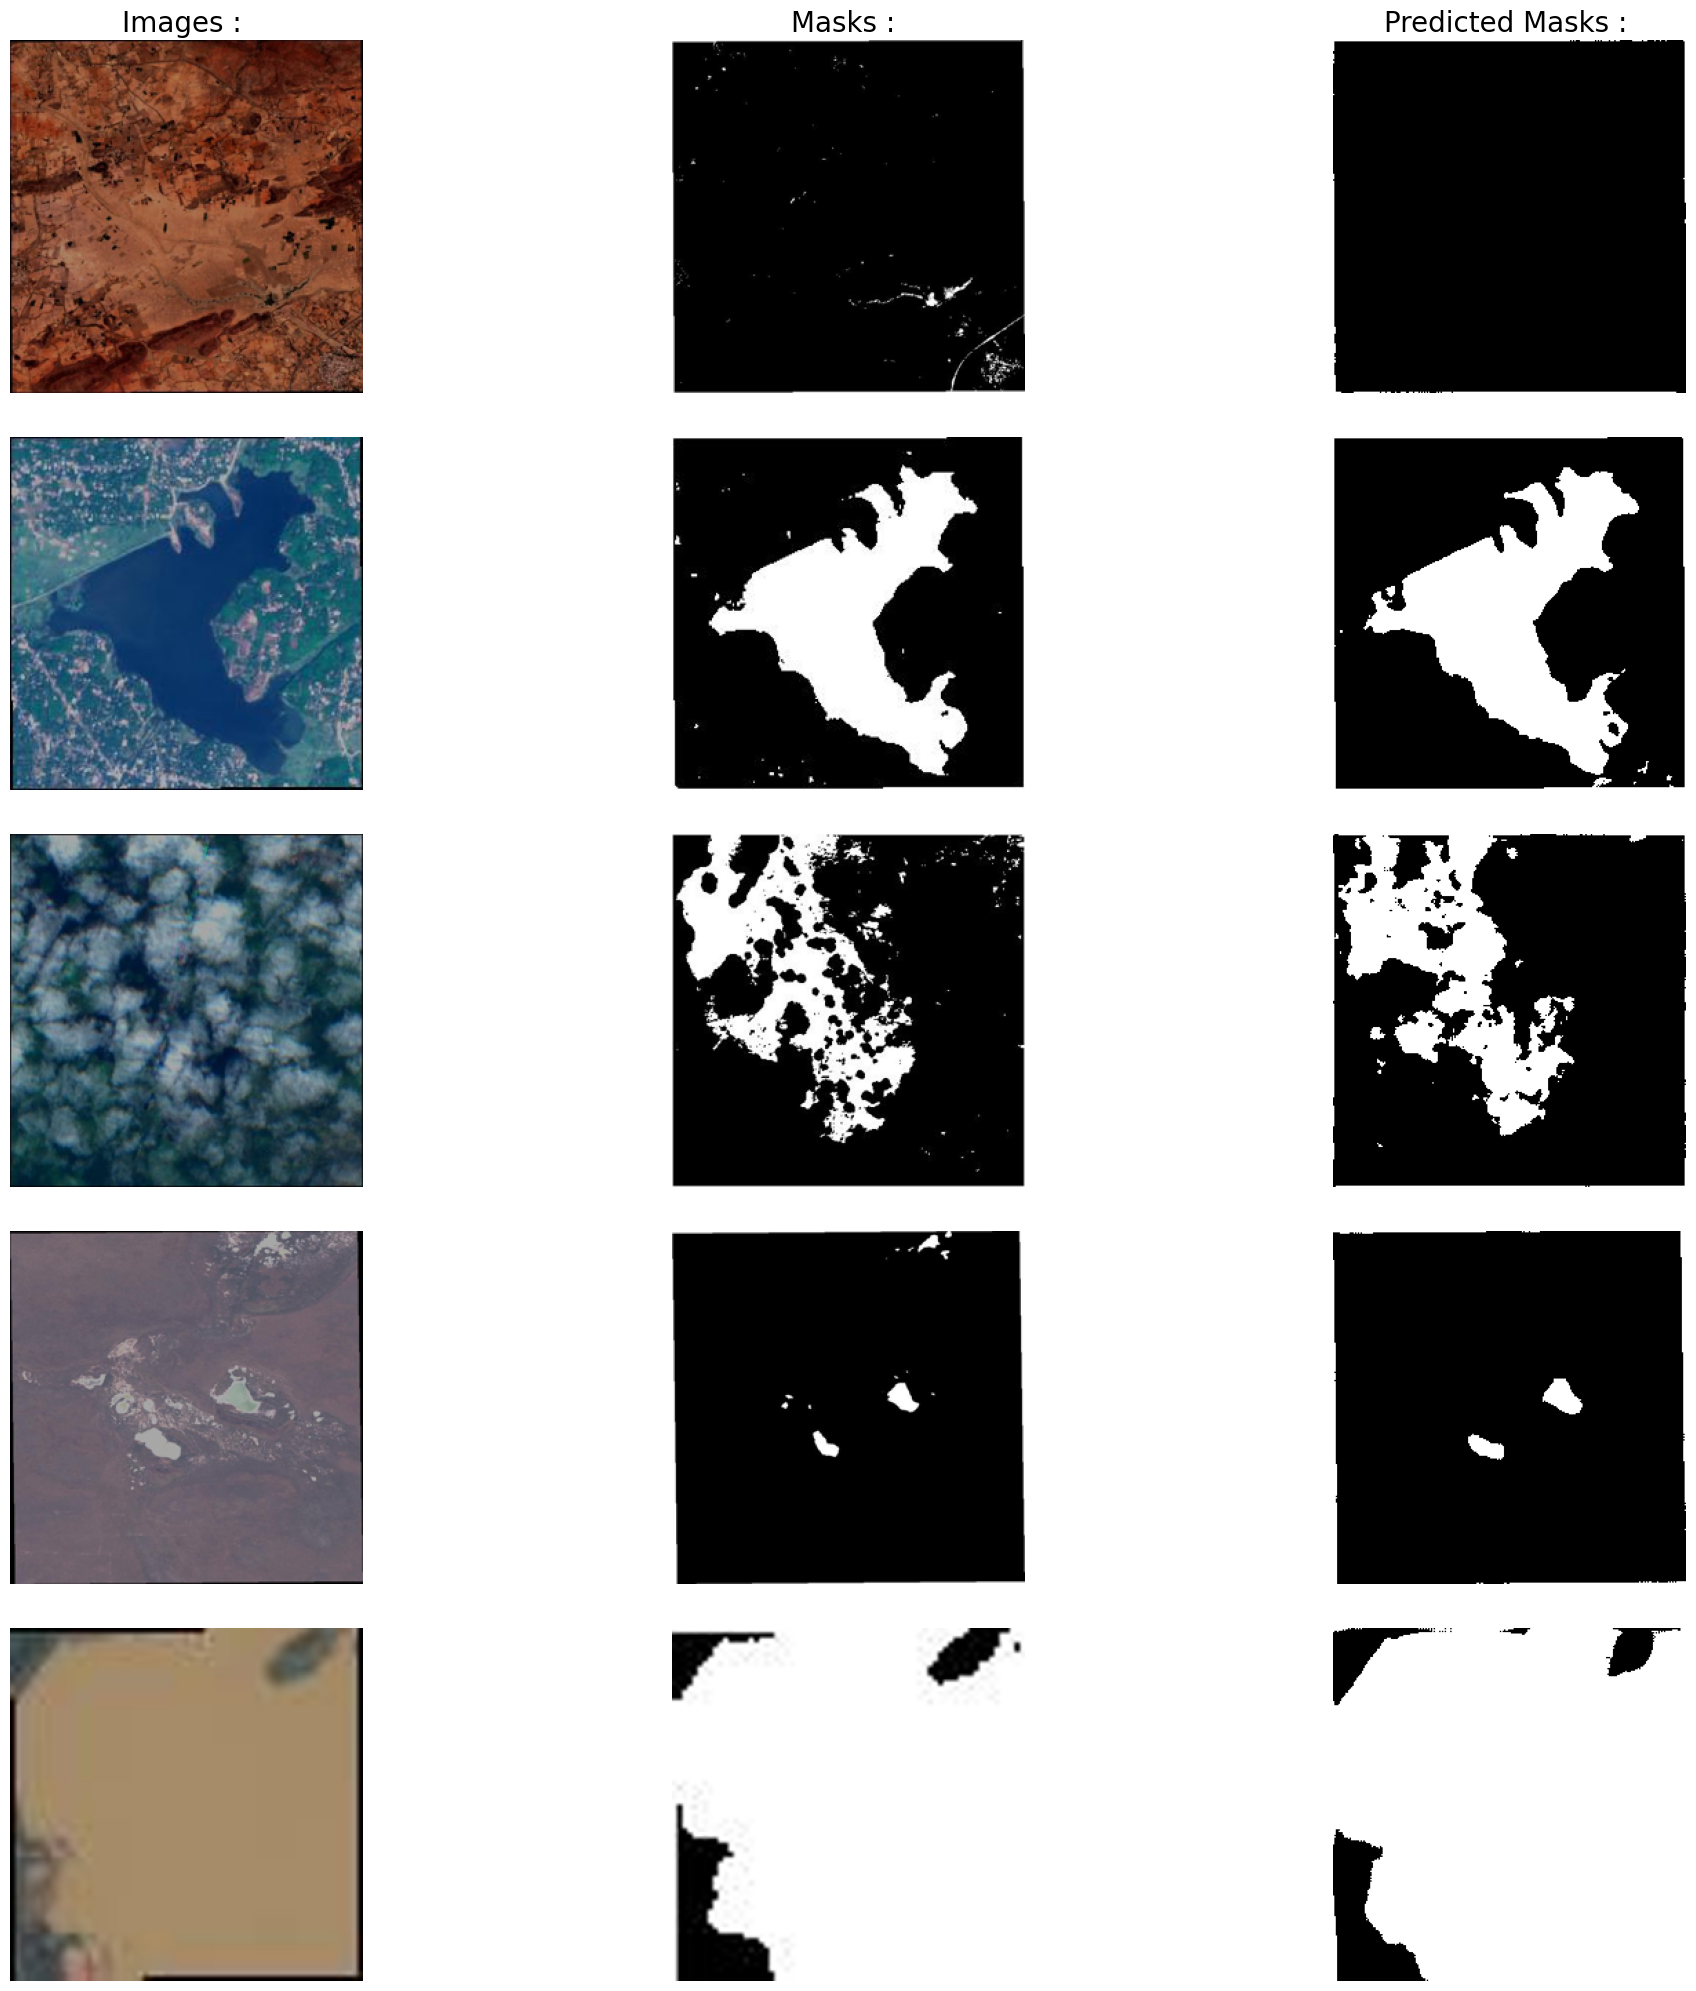

In [ ]:
indeces = np.random.randint(0, len(IMAGES), 5)

fig, ax = plt.subplots(5, 3, figsize=(20, 20))
fig.tight_layout()
ax[0, 0].set_title("Images : ", fontsize=20)
ax[0, 1].set_title("Masks : ", fontsize=20)
ax[0, 2].set_title("Predicted Masks : ", fontsize=20)
for i, idx in enumerate(indeces):
    image = Image.open(IMG_DATA + "/" + IMAGES[idx])
    mask = Image.open(MASK_DATA + "/" + MASKS[idx])
    image = image.resize((256, 256))
    mask = mask.resize((256, 256))
    predicted_mask = unet.predict(np.expand_dims(np.asarray(image, dtype=np.uint8), axis=0))
    predicted_mask = np.squeeze(predicted_mask)
    predicted_mask = ((predicted_mask > 0.5) *255).astype(np.uint8)
    pred_img = Image.fromarray(predicted_mask)
    pred_img.save(f"Predicted_mask-{i}.png")
    ax[i, 0].imshow(image)
    ax[i, 0].axis("off")
    ax[i, 1].imshow(mask)
    ax[i, 1].axis("off")
    ax[i, 2].imshow(predicted_mask, cmap="gray")
    ax[i, 2].axis("off")

In [ ]:
unet.save('unet.h5')

In [ ]:
unet.save_weights('my_w.weights.h5')


## Conclusion
Your U-Net model demonstrates **strong performance** in segmenting water bodies from Sentinel-2 satellite imagery. The training process shows effective learning, with training accuracy reaching 81.91% and validation accuracy of 79.72% at its best epoch, with corresponding losses of 0.1200 and 0.2358 respectively. While there are signs of **minor overfitting**, expected given the large number of parameters (31M+), the gap between training and validation metrics remains small, indicating a **well-generalized model**.

**Visual inspections** confirm the model's efficacy. Randomly selected test images reveal that the predicted masks closely align with the ground truth, accurately delineating water bodies. This pixel-level precision underscores the model's capability to handle complex satellite imagery.​

To further improve performance and efficiency, one can introduce data augmentation, to introduce more variability and reduce overfitting, model optimizations through pruning or lightweight U-Net variants for deployment on limited-resource platforms.

Overall, the model is well-suited for scalable, automated waterbody mapping and represents a solid foundation for further development in environmental monitoring systems.